In [1]:
%load_ext autotime

In [2]:
import tempfile
from pathlib import Path

import numpy as np
import pandas as pd
from astropy.wcs import WCS

from panoptes.utils.images import fits as fits_utils, bayer
from panoptes.utils.serializers import to_json, from_json

from panoptes.utils.time import current_time
from panoptes.utils.images import fits as fits_utils
from panoptes.utils.images import plot
from panoptes.pipeline.utils import metadata, sources
from panoptes.pipeline.scripts import image as image_processing
from panoptes.pipeline.utils.plot import plot_bg_overlay, plot_raw_bg_overlay, plot_distribution, plot_stellar_location

from IPython.display import JSON, display, Markdown
from matplotlib.figure import Figure
import seaborn as sb
from loguru import logger

logger.enable('panoptes')
sb.set_theme()

time: 2.38 s


In [3]:
current_time()

<Time object: scale='utc' format='datetime' value=2021-09-14 07:01:26.791784>

time: 3.48 ms


In [4]:
# Input parameters
fits_path = 'https://storage.googleapis.com/panoptes-images-raw/PAN001/ee04d1/20200708T095934/20200708T102527.fits.fz'
output_dir = tempfile.TemporaryDirectory().name
force_new = True

# JSON string of additional settings.
image_settings = '{}'

time: 1.24 ms


In [5]:
# Parse the image settings.
image_settings = from_json(image_settings)

# Set up output directory and filenames.
output_dir = Path(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

# Override output dir with provided.
image_settings['output_dir'] = output_dir

# Get the settings object.
settings = image_processing.Settings(**image_settings)

# Prepend the output dir to the file objects.
for file_type, file_name in settings.files:
    setattr(settings.files, file_type, output_dir / file_name)

time: 1.44 ms


In [6]:
image_uid = metadata.ObservationPathInfo(path=fits_path).get_full_id(sep='/')

time: 1.31 ms


In [7]:
Markdown(f'# Processing for {image_uid}')

# Processing for PAN001/ee04d1/20200708T095934/20200708T102527

time: 2.44 ms


### Get data

In [8]:
raw_data, header = fits_utils.getdata(str(fits_path), header=True)

# Get the path info.
path_info = metadata.ObservationPathInfo.from_fits_header(header)
wcs0 = WCS(header)

time: 240 ms


In [9]:
settings.params.camera.image_height = raw_data.shape[0]
settings.params.camera.image_width = raw_data.shape[1]

time: 396 µs


### Mask bias and outliers

In [10]:
# Subtract zero bias.
data = raw_data - settings.params.camera.zero_bias

# Mask saturated
data = np.ma.masked_greater_equal(data, settings.params.camera.saturation).astype('float32')

time: 249 ms


### Subtract RGB background

In [11]:
# Get RGB background data.
rgb_background = bayer.get_rgb_background(data=data,
                                          return_separate=True,
                                          box_size=settings.params.background.box_size,
                                          filter_size=settings.params.background.filter_size,
                                          )

time: 5.65 s


In [12]:
combined_bg_data = list()
combined_bg_residual_data = list()
for color, bg in zip(bayer.RGB, rgb_background):
    color_data = np.ma.array(data=bg.background, mask=bg.mask)
    color_residual_data = np.ma.array(data=bg.background_rms, mask=bg.mask)

    combined_bg_data.append(color_data)
    combined_bg_residual_data.append(color_residual_data)

time: 7.57 s


In [13]:
# Combine the colors
bg_data = np.ma.array(combined_bg_data).filled(0).sum(0)
bg_residual_data = np.ma.array(combined_bg_residual_data).filled(0).sum(0)
reduced_data = data - bg_data

time: 3.16 s


### Save FITS files

In [14]:
# Save reduced data and background.
image_processing.save_fits(settings.files.reduced_filename, 
          dict(
              reduced=reduced_data.data.astype(np.float32)
          ),
          header,
          force_new=force_new)

image_processing.save_fits(settings.files.extras_filename,
          dict(
              background=bg_data.astype(np.float32),
              residual=bg_residual_data.astype(np.float32),
              mask=reduced_data.mask.astype(np.uint8)
          ),
          header,
          force_new=force_new)

Saved 1 dataset(s) to /tmp/tmpnj0b802a/image.fits
Saved 3 dataset(s) to /tmp/tmpnj0b802a/extras.fits
time: 295 ms


### Plate solve

In [15]:
# Plate solve newly calibrated file.
wcs0 = image_processing.plate_solve(settings=settings)
wcs0

Plate solving /tmp/tmpnj0b802a/image.fits
Solving completed successfully for /tmp/tmpnj0b802a/image.fits


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.676656426  67.6750242597  
CRPIX : 2604.5  1738.5  
CD1_1 CD1_2  : 7.74161489119e-05  -0.0028624250829  
CD2_1 CD2_2  : -0.00286242216685  -7.86978741324e-05  
NAXIS : 5208  3476

time: 4.17 s


### Detect sources

In [16]:
detected_sources = image_processing.detect_sources(wcs0, reduced_data, bg_data, bg_residual_data, settings=settings)

Detecting sources in image
De-blending image segments
Calculating total error for data using gain=1.5
Building source catalog for deblended_segments
time: 37.8 s


### Match detected sources to catalog

In [17]:
matched_sources = image_processing.match_sources(detected_sources, wcs0, settings=settings)

Matching 3451 sources to wcs.
Getting catalog sources from bigquery for WCS
Looking up catalog stars for WCS: [[347.60912843  74.49925738]
 [310.64370539  74.1218627 ]
 [320.26432405  59.79171198]
 [339.95823508  59.99704035]]
Searching square shape with round_to=0 and pad=1.0: {'ra_max': 350.0, 'ra_min': 310.0, 'dec_max': 78.0, 'dec_min': 58.0}
sql='\n    SELECT id as picid, gaia as gaia, ra as catalog_ra, dec as catalog_dec, vmag as catalog_vmag, vmag_partition as catalog_vmag_bin, e_vmag as catalog_vmag_err, tmag as catalog_tmag, e_tmag as catalog_tmag_err, gaiamag as catalog_gaiamag, e_gaiamag as catalog_gaiamag_err, gaiabp as catalog_gaiabp_err, e_gaiabp as catalog_gaiabp, gaiarp as catalog_gaiarp_err, e_gaiarp as catalog_gaiarp, numcont as catalog_numcont, contratio as catalog_contratio \n    FROM catalog.pic\n    WHERE\n        (dec >= 58.0 AND dec <= 78.0) AND\n        (ra >= 310.0 AND ra <= 350.0) AND\n        (vmag_partition BETWEEN 6 AND 12)\n    '
Found 49242 in Vmag=[6, 13

### Get metadata from image

In [18]:
metadata_headers = image_processing.get_metadata(header, matched_sources, settings=settings)

Total sources 3161
Removing bad FITS headers (comments, history)
Getting metadata from FITS headers
Saving metadata to json file /tmp/tmpnj0b802a/metadata.json
Saved metadata to /tmp/tmpnj0b802a/metadata.json.
time: 22.7 ms


In [19]:
# Write dataframe to csv.
matched_sources['time'] = pd.to_datetime(metadata_headers['image']['time'], utc=True)
matched_sources.set_index(['picid', 'time'], inplace=True)
matched_sources.to_parquet(settings.files.sources_filename)
print(f'Matched sources saved to {settings.files.sources_filename}')

Matched sources saved to /tmp/tmpnj0b802a/sources.parquet
time: 49.7 ms


In [20]:
if settings.compress_fits:
    print(f'Compressing FITS files')
    fits_utils.fpack(str(settings.files.reduced_filename), overwrite=force_new)
    fits_utils.fpack(str(settings.files.extras_filename), overwrite=force_new)

Compressing FITS files
time: 2.14 s


## Plotting and visualizations

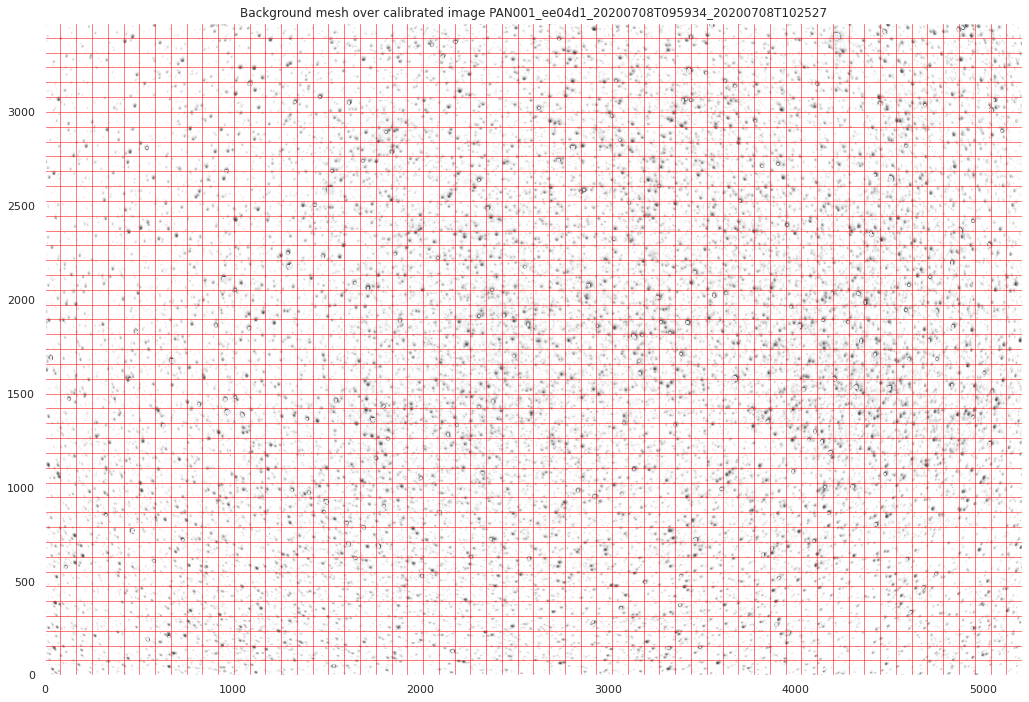

time: 3.79 s


In [21]:
plot_raw_bg_overlay(reduced_data, 
                    rgb_background=rgb_background[bayer.RGB.G], 
                    title=f'Background mesh over calibrated image {image_uid.replace("/", "_")}')

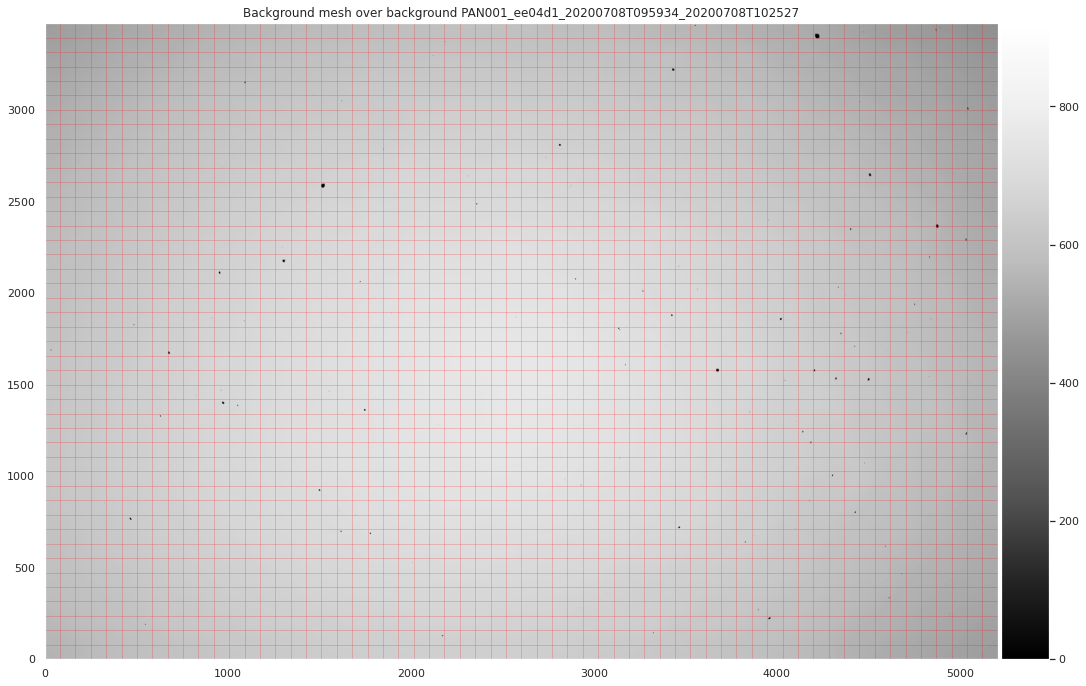

time: 4 s


In [22]:
plot_bg_overlay(bg_data,
                rgb_background[bayer.RGB.G],
                title=f'Background mesh over background {image_uid.replace("/", "_")}')

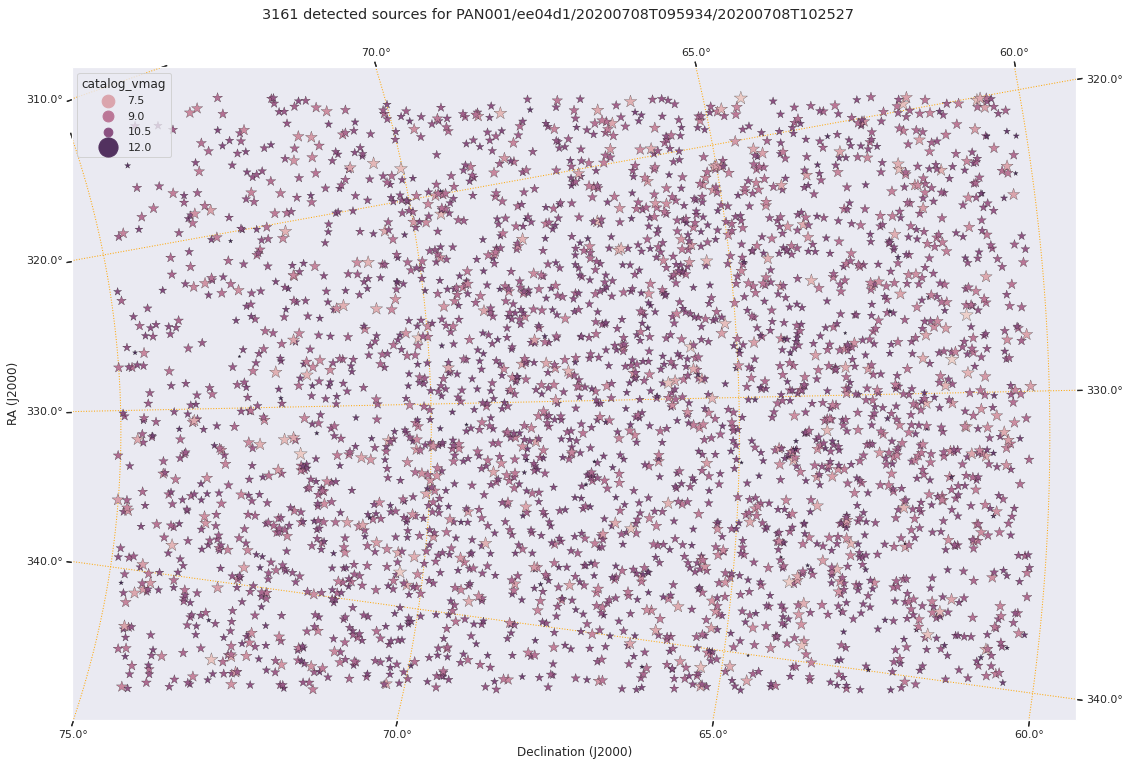

time: 856 ms


In [23]:
plot_stellar_location(matched_sources, 
                      wcs=wcs0, 
                      title=f'{len(matched_sources)} detected sources for {image_uid}')

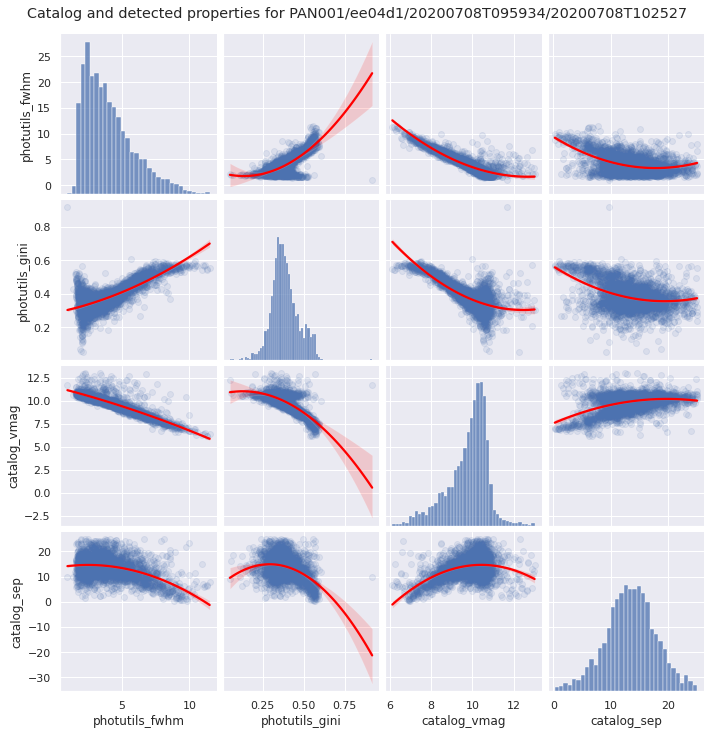

time: 7.97 s


In [24]:
dist_columns = [
    'photutils_fwhm',
    'photutils_gini',
    'catalog_vmag',
    'catalog_sep',
]

pg = sb.pairplot(matched_sources[dist_columns], kind='reg', plot_kws={'order': 2, 'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
pg.fig.suptitle(f'Catalog and detected properties for {image_uid}', y=1.02);

In [25]:
try:
    display(JSON(metadata_headers, expanded=True))
except Exception:
    from pprint import pprint
    pprint(metadata_headers)

<IPython.core.display.JSON object>

time: 3.26 ms


In [26]:
!jupyter --version

jupyter core     : 4.7.1
jupyter-notebook : 6.4.3
qtconsole        : not installed
ipython          : 7.26.0
ipykernel        : 6.0.3
jupyter client   : 6.1.12
jupyter lab      : 3.1.11
nbconvert        : 6.1.0
ipywidgets       : 7.6.4
nbformat         : 5.1.3
traitlets        : 5.0.5
time: 1.32 s


In [27]:
import json
print(json.dumps(from_json(settings.json()), indent=2))

{
  "params": {
    "camera": {
      "zero_bias": 2048.0,
      "saturation": 11530.0,
      "effective_gain": 1.5,
      "image_width": 5208,
      "image_height": 3476
    },
    "catalog": {
      "vmag_limits": [
        6,
        13
      ],
      "max_separation_arcsec": 25,
      "localbkg_width_pixels": 2,
      "detection_threshold": 10.0,
      "num_detect_pixels": 4,
      "catalog_filename": null
    },
    "background": {
      "box_size": [
        79,
        84
      ],
      "filter_size": [
        3,
        3
      ]
    }
  },
  "files": {
    "reduced_filename": "/tmp/tmpnj0b802a/image.fits",
    "extras_filename": "/tmp/tmpnj0b802a/extras.fits",
    "metadata_filename": "/tmp/tmpnj0b802a/metadata.json",
    "sources_filename": "/tmp/tmpnj0b802a/sources.parquet"
  },
  "compress_fits": true,
  "output_dir": "/tmp/tmpnj0b802a"
}
time: 5.19 ms


In [28]:
current_time()

<Time object: scale='utc' format='datetime' value=2021-09-14 07:02:52.616283>

time: 3.03 ms
